In [1]:
import torch
from torch import nn
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt

##tmp
import numpy as np

In [2]:
N=1000
epochs=25
mini_batch_size = 100

In [3]:
class NaiveCNN(nn.Module):
    def __init__(self, hidden_layer=2):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2, stride=2))
             
        #predict implicitely the class of input1 and input2 separately
        classif=[nn.Linear(64*3*3, 100),
                 nn.ReLU(inplace=True)]
        
        if hidden_layer == 1:
            classif.append(nn.Linear(100, 50))
            classif.append(nn.ReLU(inplace=True))
        elif hidden_layer == 2:
            classif.append(nn.Linear(100, 70))
            classif.append(nn.ReLU(inplace=True))
            classif.append(nn.Linear(70, 50))
            classif.append(nn.ReLU(inplace=True))

        classif.append(nn.Linear(50, 10))
        
        self.fc1 = nn.Sequential(*classif)
        self.fc2 = nn.Sequential(*classif)
        
        #predict the output from concatenated classes predictions
        self.fc3 = nn.Sequential(
            nn.Linear(20, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10,2),
            nn.Softmax(1))
            
    def forward(self, input_):
        #call the network on both input
        output1 = self.cnn(input_[:,0,:].unsqueeze(1))
        output2 = self.cnn(input_[:,0,:].unsqueeze(1))
        
        #reshape
        output1 = output1.view(output1.size()[0], -1)
        output2 = output2.view(output2.size()[0], -1)
        
        #predict class implicitely, using 2 different network
        output1 = self.fc1(output1)
        output2 = self.fc2(output2)
        
        #predict binary output
        output = self.fc3(torch.cat((output1, output2), 1))
        return output, output1, output2
    
class SharedWeight(nn.Module):
    def __init__(self, hidden_layer=0):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2, stride=2))
        
        #predict implicitely the class of both image
        classif=[nn.Linear(64*3*3, 100),
                 nn.ReLU(inplace=True)]
        
        if hidden_layer == 1:
            classif.append(nn.Linear(100, 50))
            classif.append(nn.ReLU(inplace=True))
        elif hidden_layer == 2:
            classif.append(nn.Linear(100, 70))
            classif.append(nn.ReLU(inplace=True))
            classif.append(nn.Linear(70, 50))
            classif.append(nn.ReLU(inplace=True))
            
        classif.append(nn.Linear(50, 10))
        self.fc1 = nn.Sequential(*classif)
        
        #predict the output from concatenated classes predictions
        self.fc2 = nn.Sequential(
            nn.Linear(20, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10,2),
            nn.Softmax(1))
            
    def forward_once(self, x):
        #call the classification block on an individual input
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
    
    def forward(self, input_):
        #call the network on both input, combine the outputs and final output
        output1 = self.forward_once(input_[:,0,:].unsqueeze(1))
        output2 = self.forward_once(input_[:,1,:].unsqueeze(1))
        output = self.fc2(torch.cat((output1, output2), 1))
        return output, output1, output2

def train_model(model, input_, target_, classes_=None, learn_rate_= 1e-2, lambda_=0.1, mini_batch_size=100, nb_epochs = 25):
    #classification & binary output
    criterion = nn.CrossEntropyLoss()
    
    #stochastic gradient descent
    optim = torch.optim.SGD(model.parameters(), lr=learn_rate_, momentum=0.9)

    for e in range(nb_epochs):
        for b in range(0, input_.size(0), mini_batch_size):
            #split the input in two, return the binary value and the classes of both input
            output, class_0, class_1 = model(input_.narrow(0, b, mini_batch_size))
            
            if classes_ is None:
                #no auxiliary loss
                loss = criterion(output, target_.narrow(0, b, mini_batch_size))
            else:
                #auxiliary loss
                loss = criterion(output, target_.narrow(0, b, mini_batch_size)) \
                        + lambda_*criterion(class_0, classes_.narrow(0, b, mini_batch_size)[:,0]) \
                        + lambda_*criterion(class_1, classes_.narrow(0, b, mini_batch_size)[:,1])
            
            #backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
    return loss
        
def compute_nb_errors(model, input_, target_, mini_batch_size):
    nb_error = 0
    
    for b in range(0, input_.size(0), mini_batch_size):
        output, _, _ = model(input_.narrow(0, b, mini_batch_size))
        _,pred = output.max(1)
        
        for k in range(mini_batch_size):
            if target_[b+k] != pred[k]:
                nb_error += 1
                
    return nb_error

In [4]:
learn_rates = np.logspace(-4, -1,15)
train_error = []
test_error = []
lbd = 0.23
for lr in learn_rates:
    Siamese = SharedWeight(1)
    train_input, train_target, train_classes, \
    test_input, test_target, test_classes = \
    prologue.generate_pair_sets(N)
    train_model(Siamese, train_input, train_target, train_classes, learn_rate_= lr, lambda_=lbd, mini_batch_size=mini_batch_size, nb_epochs = 25)
    train_error.append(compute_nb_errors(Siamese, train_input, train_target, mini_batch_size))
    test_error.append(compute_nb_errors(Siamese, test_input, test_target, mini_batch_size))

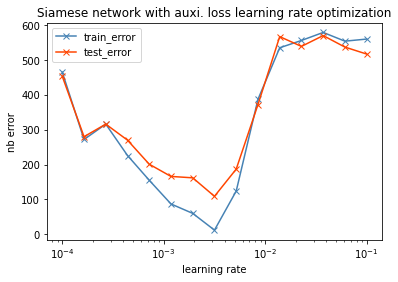

In [17]:
fig = plt.figure()
plt.semilogx(learn_rates, train_error,c='steelblue',label="train_error", marker='x')
plt.semilogx(learn_rates, test_error,c='orangered', label="test_error", marker='x')
plt.title("Siamese network with auxi. loss learning rate optimization")
plt.xlabel("learning rate")
plt.ylabel("nb error")
plt.legend()
plt.show()
fig.savefig("siame_auxi_lr.pdf") # Use fig. here

In [18]:
learn_rates[np.argmin(test_error)]

0.0031622776601683794

In [ ]:
lambdas = np.logspace(-2, 0,20)
losses_train = []
train_error = []
test_error = []
lbd = 0.1
for lbd in lambdas:
    Siamese = SharedWeight(1)
    train_input, train_target, train_classes, \
    test_input, test_target, test_classes = \
    prologue.generate_pair_sets(N)
    losses_train.append(train_model(Siamese, train_input, train_target, train_classes, learn_rate_= 2e-2, lambda_=lbd, mini_batch_size=mini_batch_size, nb_epochs = 25))
    train_error.append(compute_nb_errors(Siamese, train_input, train_target, mini_batch_size))
    test_error.append(compute_nb_errors(Siamese, test_input, test_target, mini_batch_size))

In [ ]:
fig = plt.figure()
plt.semilogx(lambdas, train_error,c='steelblue',label="train_error", marker='x')
plt.semilogx(lambdas, test_error,c='orangered', label="test_error", marker='x')
plt.title("Siamese network regularization optimization")
plt.xlabel("lambda")
plt.ylabel("nb error")
plt.legend()
plt.show()
fig.savefig("siame_auxi_lambda.pdf") # Use fig. here

In [ ]:
lambdas[np.argmin(test_error)]

In [19]:
#generate boxplot across models
SIAM_auxi_train_error = []
SIAM_auxi_test_error = []
SIAM_train_error = []
SIAM_test_error = []
NAIVE_train_error = []
NAIVE_test_error = []
SIAM_auxi_5_train_error = []
SIAM_auxi_5_test_error = []

for i in range(10):
    train_input, train_target, train_classes, \
    test_input, test_target, test_classes = \
    prologue.generate_pair_sets(N)
    
    NaiveCN = NaiveCNN(1)
    Siamese = SharedWeight(1)
    Siamese_auxi = SharedWeight(1)
    Siamese_auxi_5 = SharedWeight(2)
    
    train_model(NaiveCN, train_input, train_target, learn_rate_= 1.6e-3, lambda_=0, mini_batch_size=mini_batch_size, nb_epochs = 25)
    train_model(Siamese, train_input, train_target, learn_rate_= 1.6e-3, lambda_=0, mini_batch_size=mini_batch_size, nb_epochs = 25)
    train_model(Siamese_auxi, train_input, train_target, train_classes, learn_rate_= 3.1e-3, lambda_=0.23, mini_batch_size=mini_batch_size, nb_epochs = 25)
    train_model(Siamese_auxi_5, train_input, train_target, train_classes, learn_rate_= 1.2e-2, lambda_=0.23, mini_batch_size=mini_batch_size, nb_epochs = 25)
    
    SIAM_auxi_5_train_error.append(compute_nb_errors(Siamese_auxi_5, train_input, train_target, mini_batch_size))
    SIAM_auxi_5_test_error.append(compute_nb_errors(Siamese_auxi_5, test_input, test_target, mini_batch_size))
    SIAM_auxi_train_error.append(compute_nb_errors(Siamese_auxi, train_input, train_target, mini_batch_size))
    SIAM_auxi_test_error.append(compute_nb_errors(Siamese_auxi, test_input, test_target, mini_batch_size))
    SIAM_train_error.append(compute_nb_errors(Siamese, train_input, train_target, mini_batch_size))
    SIAM_test_error.append(compute_nb_errors(Siamese, test_input, test_target, mini_batch_size))
    NAIVE_train_error.append(compute_nb_errors(NaiveCN, train_input, train_target, mini_batch_size))
    NAIVE_test_error.append(compute_nb_errors(NaiveCN, test_input, test_target, mini_batch_size))

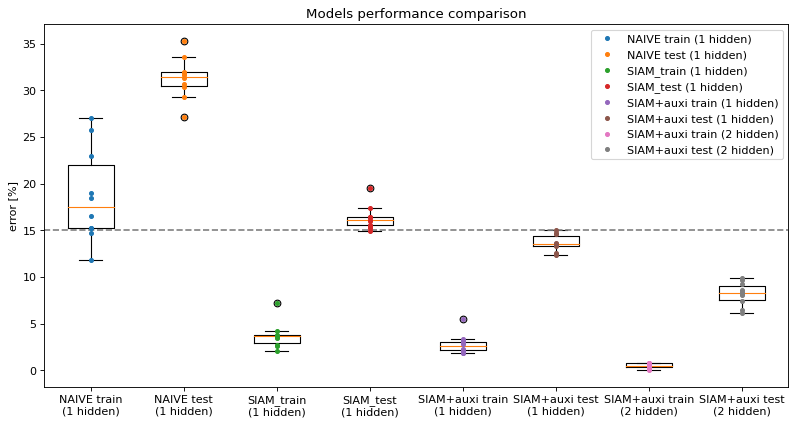

In [24]:
fig = plt.figure(figsize=(12, 6), dpi=80)
vals =[np.array(NAIVE_train_error)/10,
       np.array(NAIVE_test_error)/10,
       np.array(SIAM_train_error)/10,
       np.array(SIAM_test_error)/10,
       np.array(SIAM_auxi_train_error)/10,
       np.array(SIAM_auxi_test_error)/10,
       np.array(SIAM_auxi_5_train_error)/10,
       np.array(SIAM_auxi_5_test_error)/10
      ]
labels= ["NAIVE train\n(1 hidden)",
         "NAIVE test\n(1 hidden)",
         "SIAM_train\n(1 hidden)",
         "SIAM_test\n(1 hidden)",
         "SIAM+auxi train\n(1 hidden)",
         "SIAM+auxi test\n(1 hidden)",
         "SIAM+auxi train\n(2 hidden)",
         "SIAM+auxi test\n(2 hidden)"
        ]

plt.boxplot(vals, labels=labels, zorder=1)
for i in range(len(vals)):
    plt.plot([i+1]*10,vals[i],".", markersize=7, label=labels[i].replace('\n', ' '))
plt.hlines(15, xmin=0.5, xmax=8.5, ls='--', color='gray')
plt.title("Models performance comparison")
plt.ylabel("error [%]")
plt.legend()
plt.show()

fig.savefig("models_error_boxplot_2.pdf")

In [21]:
sum(p.numel() for p in Siamese_auxi_5.parameters() if p.requires_grad)

87878

In [22]:
sum(p.numel() for p in Siamese_auxi.parameters() if p.requires_grad)

82308

In [23]:
sum(p.numel() for p in Siamese.parameters() if p.requires_grad)

82308

In [25]:
val = [
        NAIVE_test_error,
        SIAM_test_error,
        SIAM_auxi_test_error,
        SIAM_auxi_5_test_error
        ]

In [26]:
for i in range(len(val)):
    print((np.random.choice(val[i], 1000)/10).std())

2.135913834872558
1.2856999805553393
0.83828381232134
1.2103805971676842


In [27]:
for i in range(len(val)):
    print((np.random.choice(val[i], 1000)/10).mean())

31.325100000000003
16.303800000000003
13.6849
8.209200000000001


In [28]:
for i in range(len(val)):
    print(100-(np.random.choice(val[i], 1000)/10).mean())

68.6732
83.6796
86.3292
91.7457
